<a href="https://colab.research.google.com/github/dajuanyoung/Project---Food-Desert/blob/main/Team_58_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install libspatialindex-dev
!pip3 install rtree pygeos
!pip install geopandas
!pip install --upgrade -q pygsheets
!pip install -q xlrd
!pip3 install shap

import geopandas as gpd
import shap
import os
import json
import numpy as np
import io
import pandas as pd
from google.colab import files
import google.auth
from google.colab import auth
import pygsheets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shapely
from matplotlib import pyplot as plt

In [ ]:
#documentation for pyghsheets
#https://www.pingshiuanchua.com/blog/post/intro-to-colaboratory-and-linking-it-to-google-sheets
auth.authenticate_user()
credentials, _ = google.auth.default()
gc = pygsheets.client.Client(credentials)

In [ ]:
#documentation for pyghsheets
sheet = gc.open_by_key('1WUKY_4fMATWIuzuAyNLN07usk7tBI-YYdQpPFxqulU0') #the key is the long string of letters and numbers in your spreadsheet's URL after "/d/"

In [ ]:
def import_tab(tab_name,sheet):
  tab = sheet.worksheet_by_title(tab_name)
  df = tab.get_as_df()
  return df

In [ ]:
df = import_tab('Sheet1',sheet)

In [ ]:
df.head(2)

,FIPS,State,County,Region,Division,PCT_NHNA10,PCT_NHASIAN10,PCT_NHBLACK10,PCT_NHPI10,PCT_HISP10,PCT_65OLDER10,PCT_18YOUNGER10,PCT_NHWHITE10,PCT_LACCESS_CHILD10,LACCESS_CHILD10,PCT_LACCESS_HHNV10,LACCESS_HHNV10,PCT_LACCESS_LOWI10,LACCESS_LOWI10,METRO13,PERPOV10,PCT_LACCESS_POP10,LACCESS_POP10,PCT_LACCESS_SENIORS10,LACCESS_SENIORS10,PERCHLDPOV10,MILK_PRICE10,MILK_SODA_PRICE10,SODA_PRICE10,PC_SNAPBEN10,PCT_FREE_LUNCH10,PCT_REDUCED_LUNCH10,PCT_DIABETES_ADULTS10,PCT_OBESE_ADULTS10,CHILDPOVRATE10,MEDHHINC10,POVRATE10,SNAP_BBCE10,SNAP_FACEWAIVER10,SNAP_OAPP10,SNAP_PART_RATE10,SNAP_REPORTSIMPLE10,SNAP_VEHEXCL10,SNAPS10,SNAPSPTH10,GROC11,GROCPTH11,SUPERC11,SUPERCPTH11,CONVS11,CONVSPTH11,SPECS11,SPECSPTH11,WICS11,WICSPTH11,FFR11,FFRPTH11,FSR11,FSRPTH11,SNAP_PART_RATE11,PC_WIC_REDEMP11,REDEMP_WICS11,RECFAC11,RECFACPTH11,GROC10,GROCPTH10,RECFAC10,RECFACPTH10,DIRSALES_FARMS09,PCT_LOCLFARM09
0,1001,AL,Autauga,South,East South Central,0.397647,0.855766,17.582599,0.040314,2.400542,11.995382,26.777959,77.246156,8.837112,4822.500269,3.284786,664.216487,9.79353,5344.427472,1,0,33.769657,18428.43969,4.376378,2388.233228,0,0.970305,0.923289,0.972216,16.599055,36.116721,6.886107,11.8,30.5,17.5,53049,11.9,1,1,0,79,1,1,49,0.897913,5,0.090581,1,0.018116,31,0.561604,1,0.018116,5,0.09047,34,0.615953,32,0.579721,84.02,15.612932,172391.75,4,0.072465,6,0.109949,4,0.073299,23,0.453148
1,1003,AL,Baldwin,South,East South Central,0.628755,0.735193,9.308425,0.043343,4.384824,16.771185,22.987408,83.504787,4.343199,7916.131932,2.147827,1571.779915,5.460261,9952.144027,1,0,19.318473,35210.81408,3.51357,6404.008603,0,1.01769,0.940165,1.001391,13.484977,36.761939,5.54234,11.8,26.6,20.2,47618,13.3,1,1,0,79,1,1,132,0.72422,27,0.144746,6,0.032166,107,0.573622,20,0.107219,26,0.139248,121,0.648675,216,1.157966,84.02,17.107496,122739.7109,16,0.085775,25,0.137163,16,0.087784,118,0.656


In [ ]:
df = df.drop_duplicates()

In [ ]:
#converts every numerical variable in a df to float and the identifier, categorical variables to object type
def correct_var_type(df):
  df = df.replace(r'^\s+$', np.nan, regex=True).replace('',np.nan)
  for var in df.columns:
    if var in cat_columns:
      df[var] = df[var].astype('object')
    else:
      df[var] = df[var].astype('float')
  return df

In [ ]:
cat_columns = ['FIPS','State','County','Region','Division']
df = correct_var_type(df)
df['empty_flag'] = df.count(axis=1) - len(cat_columns)
df = df[df['empty_flag'] > 0]
df2 = df[df['empty_flag'] == 65]
df2 = df2.drop(columns = ['empty_flag'])
df = df.drop(columns = ['empty_flag'])

In [ ]:
df.shape

(3146, 70)

In [ ]:
df2.shape[0]/df.shape[0]

0.548951048951049

In [ ]:
#Decision Tree work - MD

In [ ]:
x = ['PCT_NHNA10','PCT_NHASIAN10','PCT_NHBLACK10','PCT_NHPI10','PCT_HISP10','PCT_65OLDER10','PCT_18YOUNGER10','PCT_NHWHITE10','PCT_LACCESS_CHILD10','LACCESS_CHILD10',
     'PCT_LACCESS_HHNV10','LACCESS_HHNV10','PCT_LACCESS_LOWI10','LACCESS_LOWI10','METRO13','PERPOV10','PCT_LACCESS_POP10','LACCESS_POP10','PCT_LACCESS_SENIORS10','LACCESS_SENIORS10',
     'PERCHLDPOV10','MILK_PRICE10','MILK_SODA_PRICE10','SODA_PRICE10','PC_SNAPBEN10','PCT_FREE_LUNCH10','PCT_REDUCED_LUNCH10','PCT_DIABETES_ADULTS10','CHILDPOVRATE10',
     'MEDHHINC10','POVRATE10','SNAP_BBCE10','SNAP_FACEWAIVER10','SNAP_OAPP10','SNAP_PART_RATE10','SNAP_REPORTSIMPLE10','SNAP_VEHEXCL10','SNAPS10','SNAPSPTH10','GROC11','GROCPTH11','SUPERC11',
     'SUPERCPTH11','CONVS11','CONVSPTH11','SPECS11','SPECSPTH11','WICS11','WICSPTH11','FFR11','FFRPTH11','FSR11','FSRPTH11','SNAP_PART_RATE11','PC_WIC_REDEMP11','REDEMP_WICS11','RECFAC11',
     'RECFACPTH11','GROC10','GROCPTH10','RECFAC10','RECFACPTH10','DIRSALES_FARMS09','PCT_LOCLFARM09']

y = ['PCT_OBESE_ADULTS10']

In [ ]:
#Random Forest Built-in Feature Importance
#https://mljar.com/blog/feature-importance-in-random-forest/

In [ ]:
#Random Forest Model
#https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

#split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(df2[x], df2[y], test_size=0.25, random_state=12)

#fit model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, np.ravel(y_train))

RandomForestRegressor()

In [ ]:
#built model on full data
#Next step is to look at feature importance using 3 methods
#https://mljar.com/blog/feature-importance-in-random-forest/

In [ ]:
rf.feature_importances_

array([1.04320245e-02, 1.04646628e-02, 9.97284054e-03, 7.34148751e-03,
       1.19211838e-02, 3.18709304e-02, 2.05441013e-02, 1.56635359e-02,
       3.49553595e-03, 3.31134314e-03, 8.38542052e-03, 5.23487065e-03,
       5.08635539e-03, 3.01467881e-03, 5.68036620e-04, 1.25118037e-03,
       4.61926168e-03, 2.54356489e-03, 7.43063267e-03, 7.86120208e-03,
       2.79578101e-04, 8.19610534e-03, 6.72464884e-03, 1.65632596e-02,
       2.23761559e-02, 4.35936548e-02, 9.14753639e-03, 4.71037419e-01,
       4.58422392e-03, 7.89623563e-03, 7.51513827e-03, 1.15253738e-03,
       5.05050408e-04, 8.88829019e-04, 7.22683502e-03, 1.50043679e-04,
       9.03072247e-05, 3.08715425e-03, 8.14030300e-03, 5.26294259e-03,
       6.69490228e-03, 1.03955931e-03, 6.23928344e-03, 3.82651795e-03,
       9.12423280e-03, 5.60266241e-03, 1.09814426e-02, 2.82100403e-03,
       6.14434094e-03, 2.93413736e-03, 8.77134254e-03, 3.49062836e-02,
       2.88970897e-02, 6.09779451e-03, 9.09690366e-03, 6.27624779e-03,
      

In [ ]:
plt.rcParams.update({'figure.figsize': (18.0, 15.0)})
#plt.barh(x, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

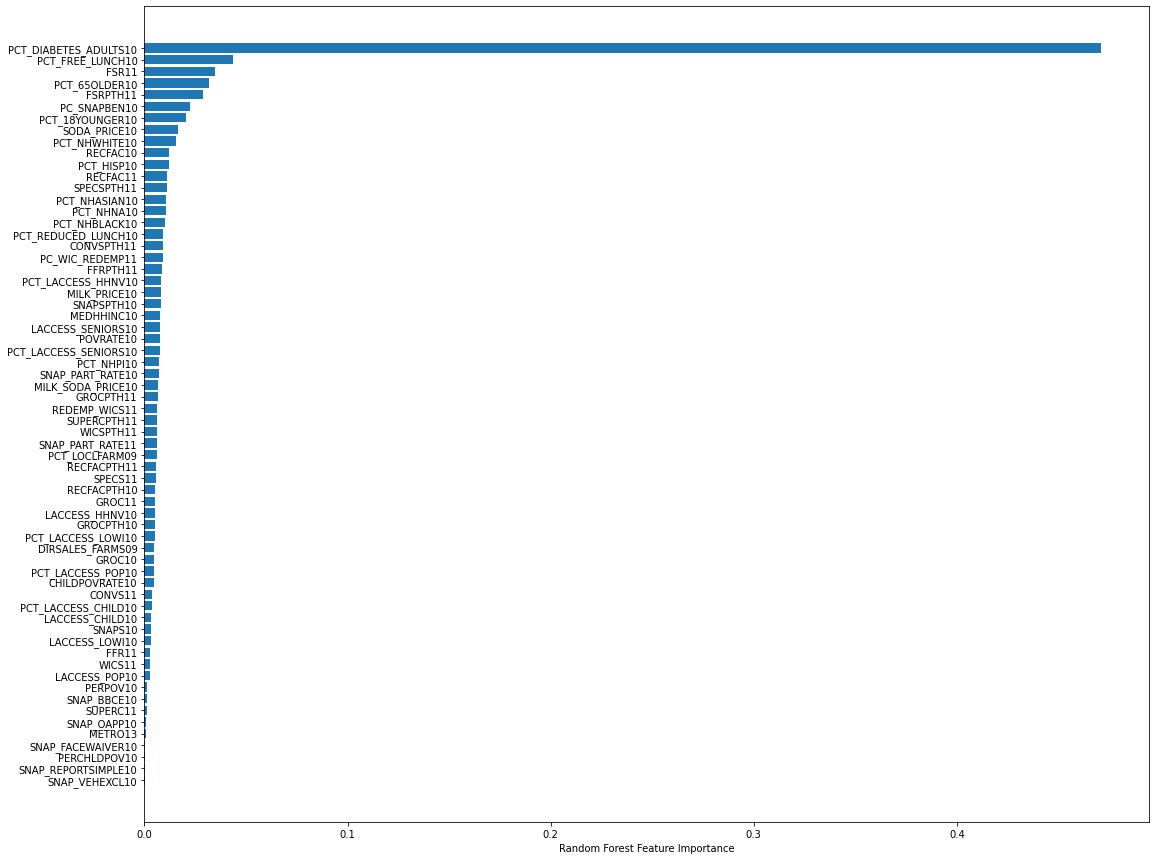

In [ ]:
sorted_idx = rf.feature_importances_.argsort()
sorted = [x[var] for var in sorted_idx]
plt.barh(sorted, rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
#permutation based feature importance
#https://mljar.com/blog/feature-importance-in-random-forest/

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

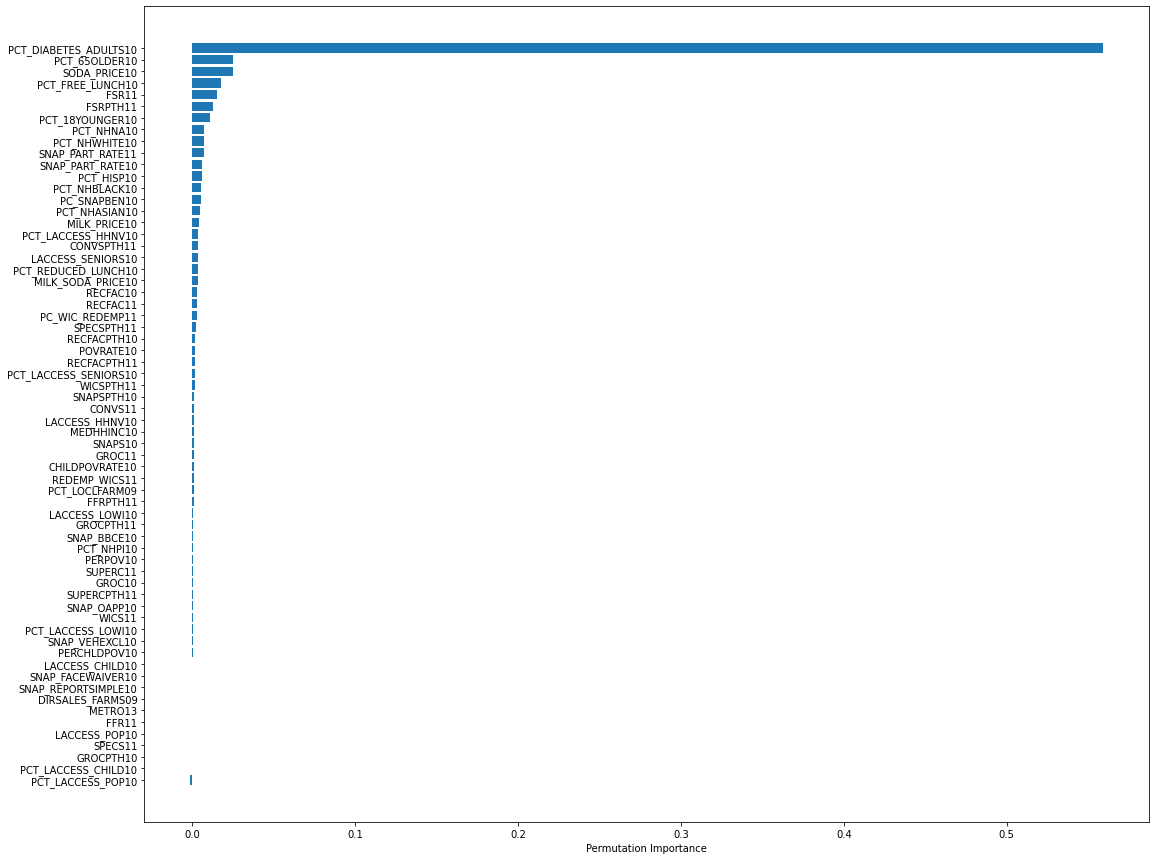

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
sorted = [x[var] for var in sorted_idx]
plt.barh(sorted, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
#Feature Importance Computed with SHAP Values
#https://mljar.com/blog/feature-importance-in-random-forest/

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

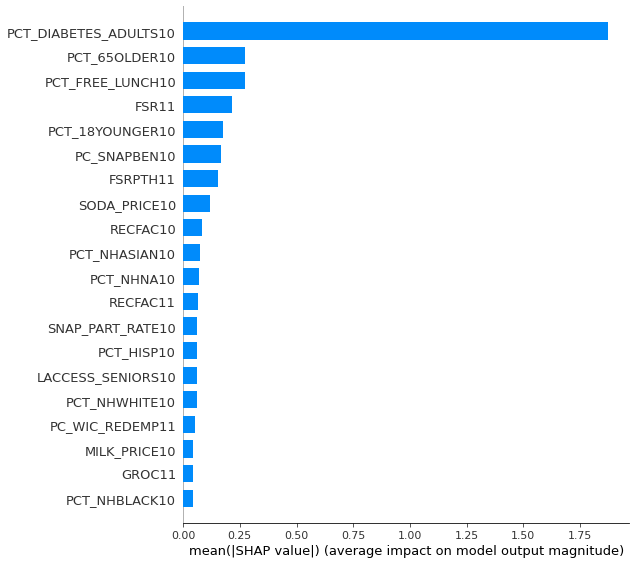

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

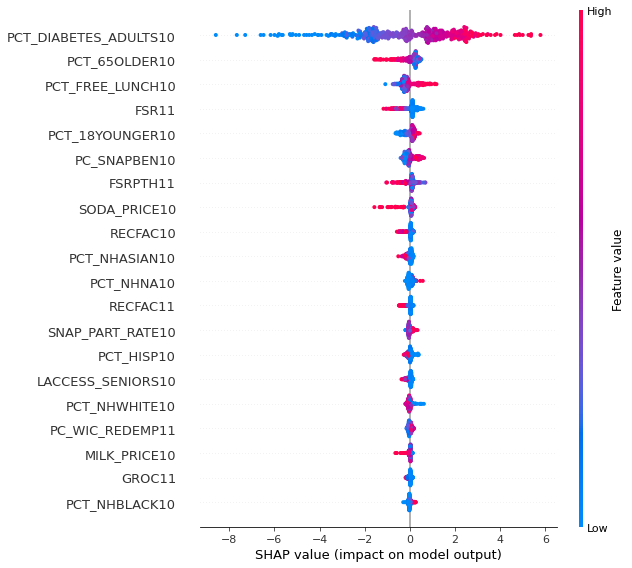

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
#Random Forest Model
#https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

In [ ]:
#Random Forest Model
#https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

#split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(df2[x], df2[y], test_size=0.20, random_state=12)

#fit model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, np.ravel(y_train))

#use model to predict using our test set of x-variables
Y_pred = rf.predict(X_test)

#Calculate Performance metrics by comparing obesity rate predictions from above to the actual obesity rates from the y-testing set
errors = abs(Y_pred - np.array(y_test))

print('Metrics for Random Forest Trained on Expanded Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / np.array(y_test)))

# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Expanded Data
Average absolute error: 4.0 degrees.
Accuracy: 86.19 %.


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x, importances)]
# Sort the feature importances by most important first
feature_importances.sort(key=lambda x:x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PCT_DIABETES_ADULTS10 Importance: 0.467
Variable: PC_SNAPBEN10         Importance: 0.039
Variable: PCT_FREE_LUNCH10     Importance: 0.032
Variable: PCT_65OLDER10        Importance: 0.031
Variable: FSRPTH11             Importance: 0.03
Variable: FSR11                Importance: 0.029
Variable: PCT_18YOUNGER10      Importance: 0.02
Variable: PCT_NHWHITE10        Importance: 0.015
Variable: SODA_PRICE10         Importance: 0.015
Variable: PCT_NHNA10           Importance: 0.013
Variable: RECFAC10             Importance: 0.013
Variable: PCT_NHBLACK10        Importance: 0.012
Variable: SPECSPTH11           Importance: 0.012
Variable: PCT_NHASIAN10        Importance: 0.011
Variable: PCT_HISP10           Importance: 0.011
Variable: LACCESS_SENIORS10    Importance: 0.011
Variable: RECFAC11             Importance: 0.011
Variable: PCT_LACCESS_HHNV10   Importance: 0.009
Variable: PCT_LACCESS_SENIORS10 Importance: 0.009
Variable: MILK_PRICE10         Importance: 0.009
Variable: CONVSPTH11

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

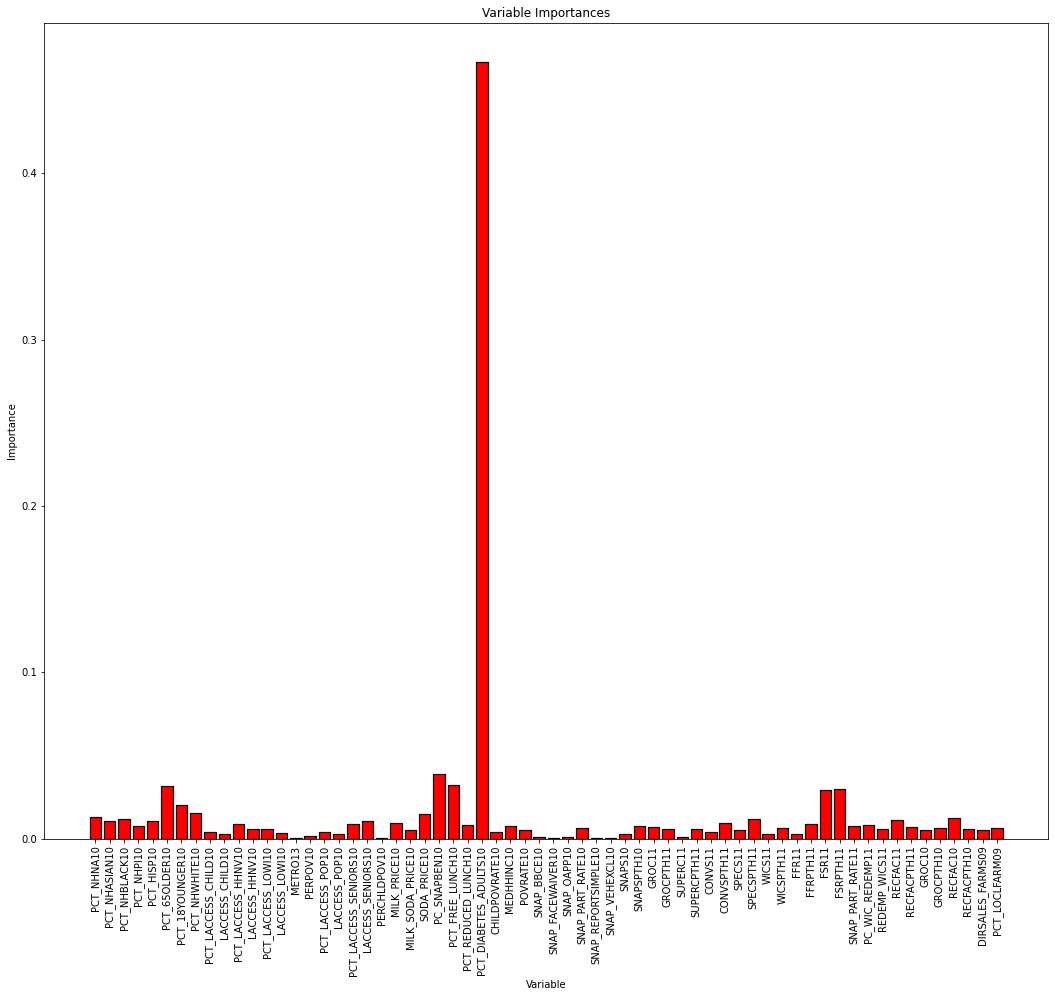

In [ ]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, x, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

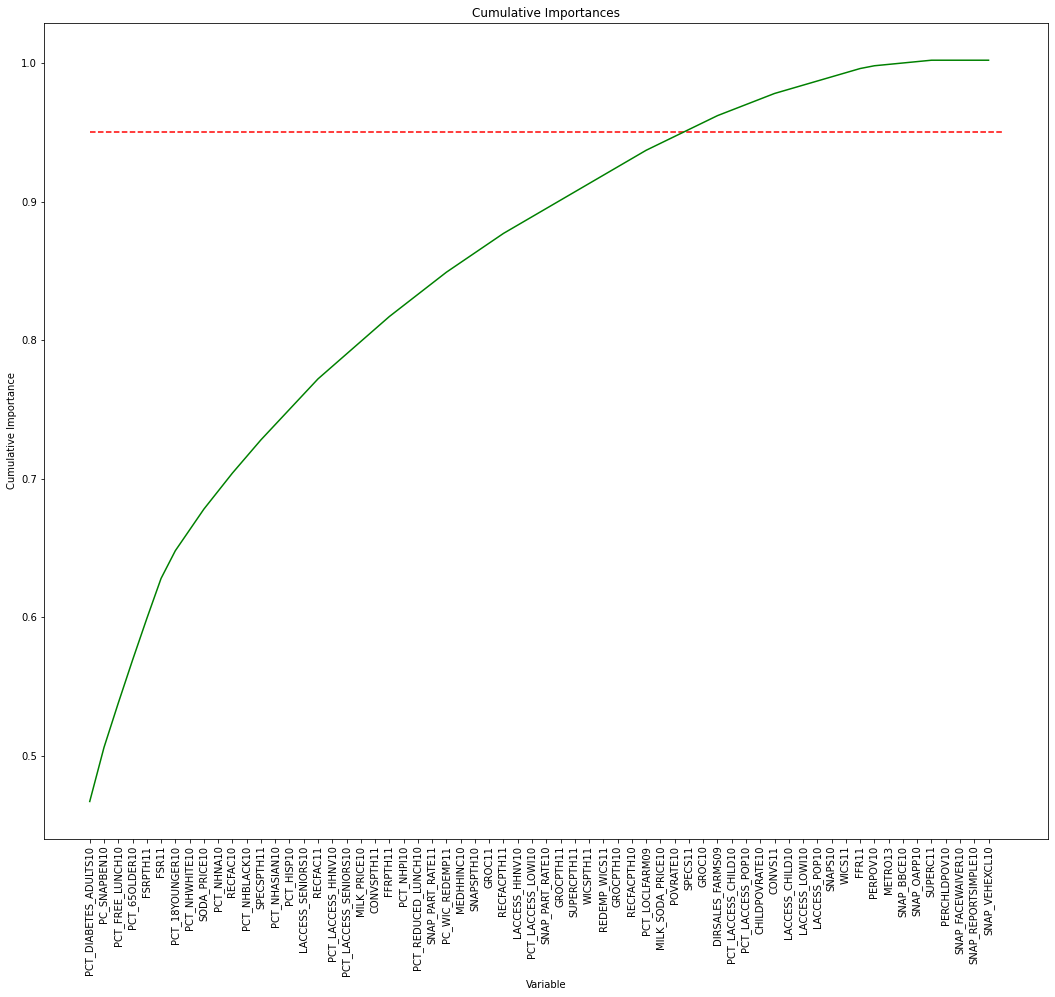

In [ ]:
#cumulative importance graph that shows the contribution to the overall importance of each additional variable. The dashed line is drawn at 95% of total importance accounted for.

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 43


In [ ]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:42]]
# Find the columns of the most important features
important_indices = [x.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_features = X_train.iloc[:, important_indices]
important_test_features = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (1381, 42)
Important test features shape: (346, 42)


In [ ]:
# Train the expanded model on only the important features
rf.fit(important_train_features, np.ravel(y_train));
# Make predictions on test data
predictions = rf.predict(important_test_features)
# Performance metrics
errors = abs(predictions - np.array(y_test))
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.array(y_test))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 3.97 degrees.
Accuracy: 86.29 %.


In [ ]:
#model stays roughly as accurate (depending on train/test split) by reducing features from 64 to 43 (to cover 95% cumulative importance)

In [ ]:
#INTERPOLATED DF

In [ ]:
df_interpolated = df.copy()

In [ ]:
all_vars = x + y

In [ ]:
for var in all_vars:
  df_interpolated[var] = df_interpolated[var].interpolate()

In [ ]:
#Random Forest Model
#https://towardsdatascience.com/improving-random-forest-in-python-part-1-893916666cd

#split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(df_interpolated[x], df_interpolated[y], test_size=0.2, random_state=12)

#fit model
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, np.ravel(y_train))

#use model to predict using our test set of x-variables
Y_pred = rf.predict(X_test)

#Calculate Performance metrics by comparing obesity rate predictions from above to the actual obesity rates from the y-testing set
errors = abs(Y_pred - np.array(y_test))

print('Metrics for Random Forest Trained on Expanded Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / np.array(y_test)))

# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Expanded Data
Average absolute error: 4.25 degrees.
Accuracy: 85.2 %.


In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 3)) for feature, importance in zip(x, importances)]
# Sort the feature importances by most important first
feature_importances.sort(key=lambda x:x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: PCT_DIABETES_ADULTS10 Importance: 0.509
Variable: PCT_65OLDER10        Importance: 0.046
Variable: PCT_NHWHITE10        Importance: 0.032
Variable: SODA_PRICE10         Importance: 0.028
Variable: FSRPTH11             Importance: 0.022
Variable: PCT_18YOUNGER10      Importance: 0.02
Variable: PCT_FREE_LUNCH10     Importance: 0.017
Variable: FSR11                Importance: 0.015
Variable: PCT_HISP10           Importance: 0.013
Variable: PCT_NHASIAN10        Importance: 0.012
Variable: SNAP_PART_RATE11     Importance: 0.012
Variable: PCT_NHNA10           Importance: 0.011
Variable: PCT_NHBLACK10        Importance: 0.011
Variable: PCT_REDUCED_LUNCH10  Importance: 0.011
Variable: MEDHHINC10           Importance: 0.01
Variable: PC_WIC_REDEMP11      Importance: 0.01
Variable: LACCESS_SENIORS10    Importance: 0.009
Variable: MILK_PRICE10         Importance: 0.009
Variable: MILK_SODA_PRICE10    Importance: 0.009
Variable: PC_SNAPBEN10         Importance: 0.009
Variable: SNAP_PART_RA

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

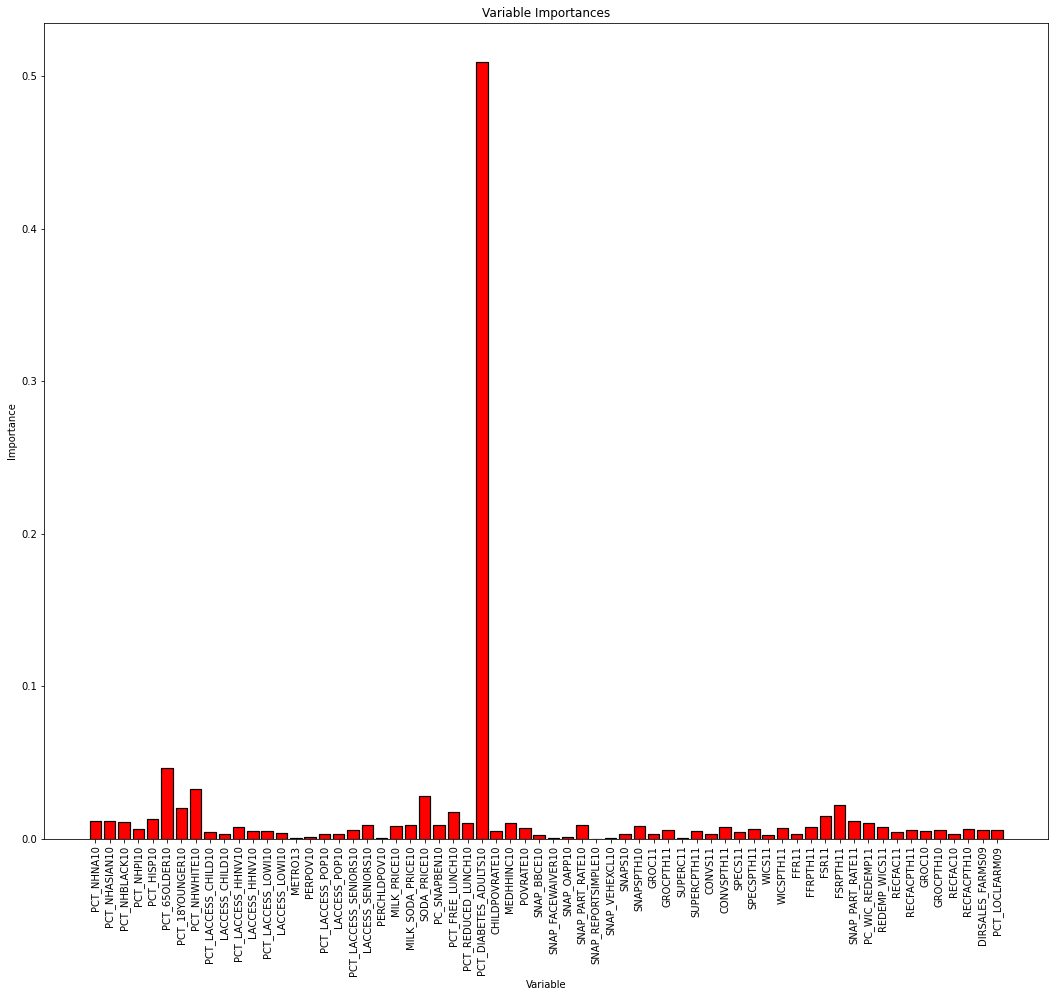

In [ ]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, x, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

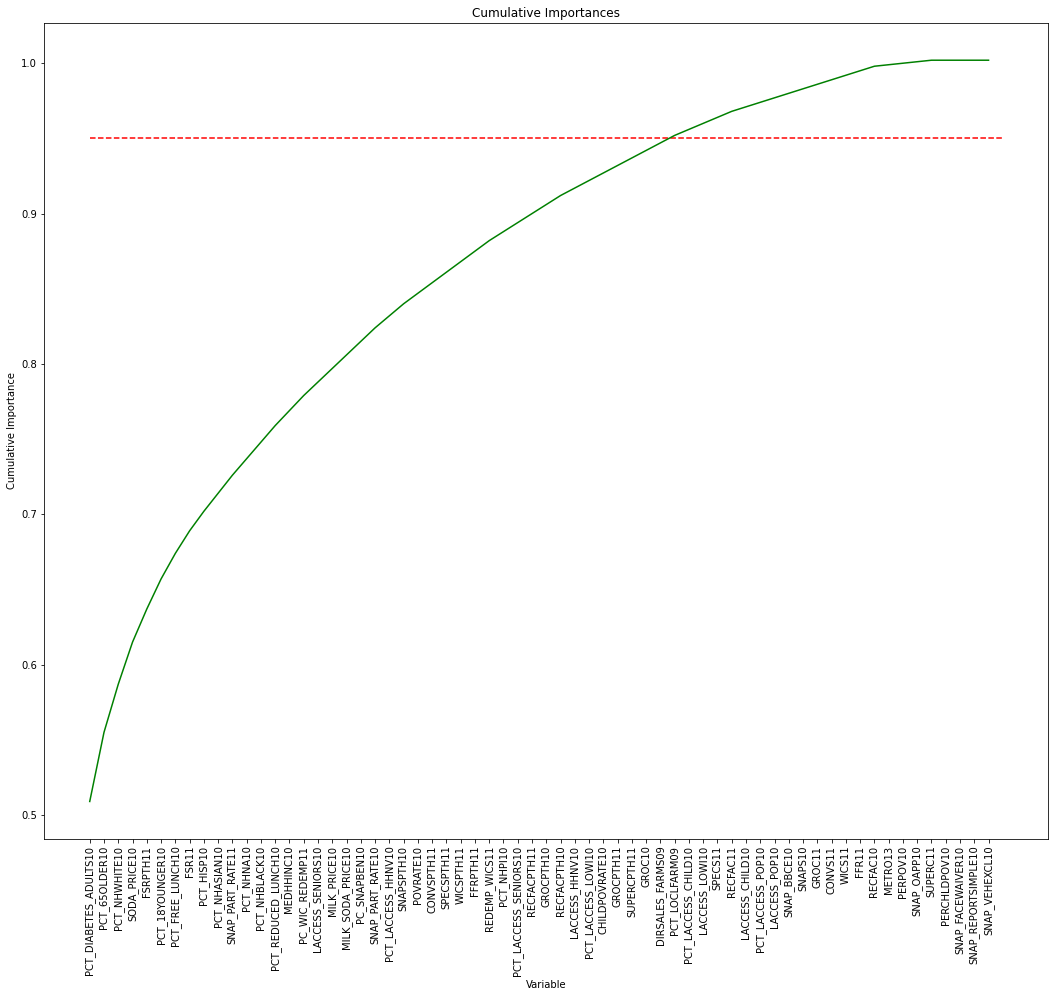

In [ ]:
#cumulative importance graph that shows the contribution to the overall importance of each additional variable. The dashed line is drawn at 95% of total importance accounted for.

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [ ]:
feature_importances[0:15]

[('PCT_DIABETES_ADULTS10', 0.509),
 ('PCT_65OLDER10', 0.046),
 ('PCT_NHWHITE10', 0.032),
 ('SODA_PRICE10', 0.028),
 ('FSRPTH11', 0.022),
 ('PCT_18YOUNGER10', 0.02),
 ('PCT_FREE_LUNCH10', 0.017),
 ('FSR11', 0.015),
 ('PCT_HISP10', 0.013),
 ('PCT_NHASIAN10', 0.012),
 ('SNAP_PART_RATE11', 0.012),
 ('PCT_NHNA10', 0.011),
 ('PCT_NHBLACK10', 0.011),
 ('PCT_REDUCED_LUNCH10', 0.011),
 ('MEDHHINC10', 0.01)]

In [ ]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 42


In [ ]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:42]]
# Find the columns of the most important features
important_indices = [x.index(feature) for feature in important_feature_names]
# Create training and testing sets with only the important features
important_train_features = X_train.iloc[:, important_indices]
important_test_features = X_test.iloc[:, important_indices]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (2516, 42)
Important test features shape: (630, 42)


In [ ]:
# Train the expanded model on only the important features
rf.fit(important_train_features, np.ravel(y_train));
# Make predictions on test data
predictions = rf.predict(important_test_features)
# Performance metrics
errors = abs(predictions - np.array(y_test))
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / np.array(y_test))
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 4.25 degrees.
Accuracy: 85.2 %.


In [ ]:
#reduced from 70 variables to 42 but accuracy barely budged